# Reconocimento de horas en relos analógico

Se utiliza el [dataset de relojes de Kaggles](https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification) para entrenar un modelo de reconocimiento de horas en relojes analógicos.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
import zipfile
import numpy as np
import os


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
def imshow(pImage):
    plt.imshow(cv2.cvtColor(pImage.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis("off")

## Decompresión de imágenes

Descomprimir dataset para trabajar con ello. Estos ficheros no se subiran al github

In [5]:
local_zip = './tmp/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./Assets/dataset')
zip_ref.close()

## Lectura de datos

## Lectura fichero csv

In [6]:
root_dir = './Assets/dataset'
csv_data = pd.read_csv(os.path.join(root_dir,'clocks.csv'))

In [7]:
hours_dict = pd.Series(csv_data['labels'].values, index=csv_data['class index']).to_dict()

In [8]:
train_labels = csv_data[csv_data['data set'] == "train"]['class index'].values
test_labels = csv_data[csv_data['data set'] == "test"]['class index'].values
valid_labels = csv_data[csv_data['data set'] == "valid"]['class index'].values

train_images_dir = csv_data[csv_data['data set'] == "train"]['filepaths'].values
test_images_dir = csv_data[csv_data['data set'] == "test"]['filepaths'].values
valid_images_dir = csv_data[csv_data['data set'] == "valid"]['filepaths'].values

In [9]:
print("Train shape", train_labels.shape)
print("Test shape", test_labels.shape)
print("Valid shape", valid_labels.shape)

Train shape (11520,)
Test shape (1440,)
Valid shape (1440,)


In [22]:
print("Class types", len(np.unique(train_labels)))

Class types 144


### Mostrar imagenes aleatorias

[ 7270   860  5390  5191 11284  5734  6265   466  4426  5578 11363 11111
  8322  1685   769 10583  6949  2433]


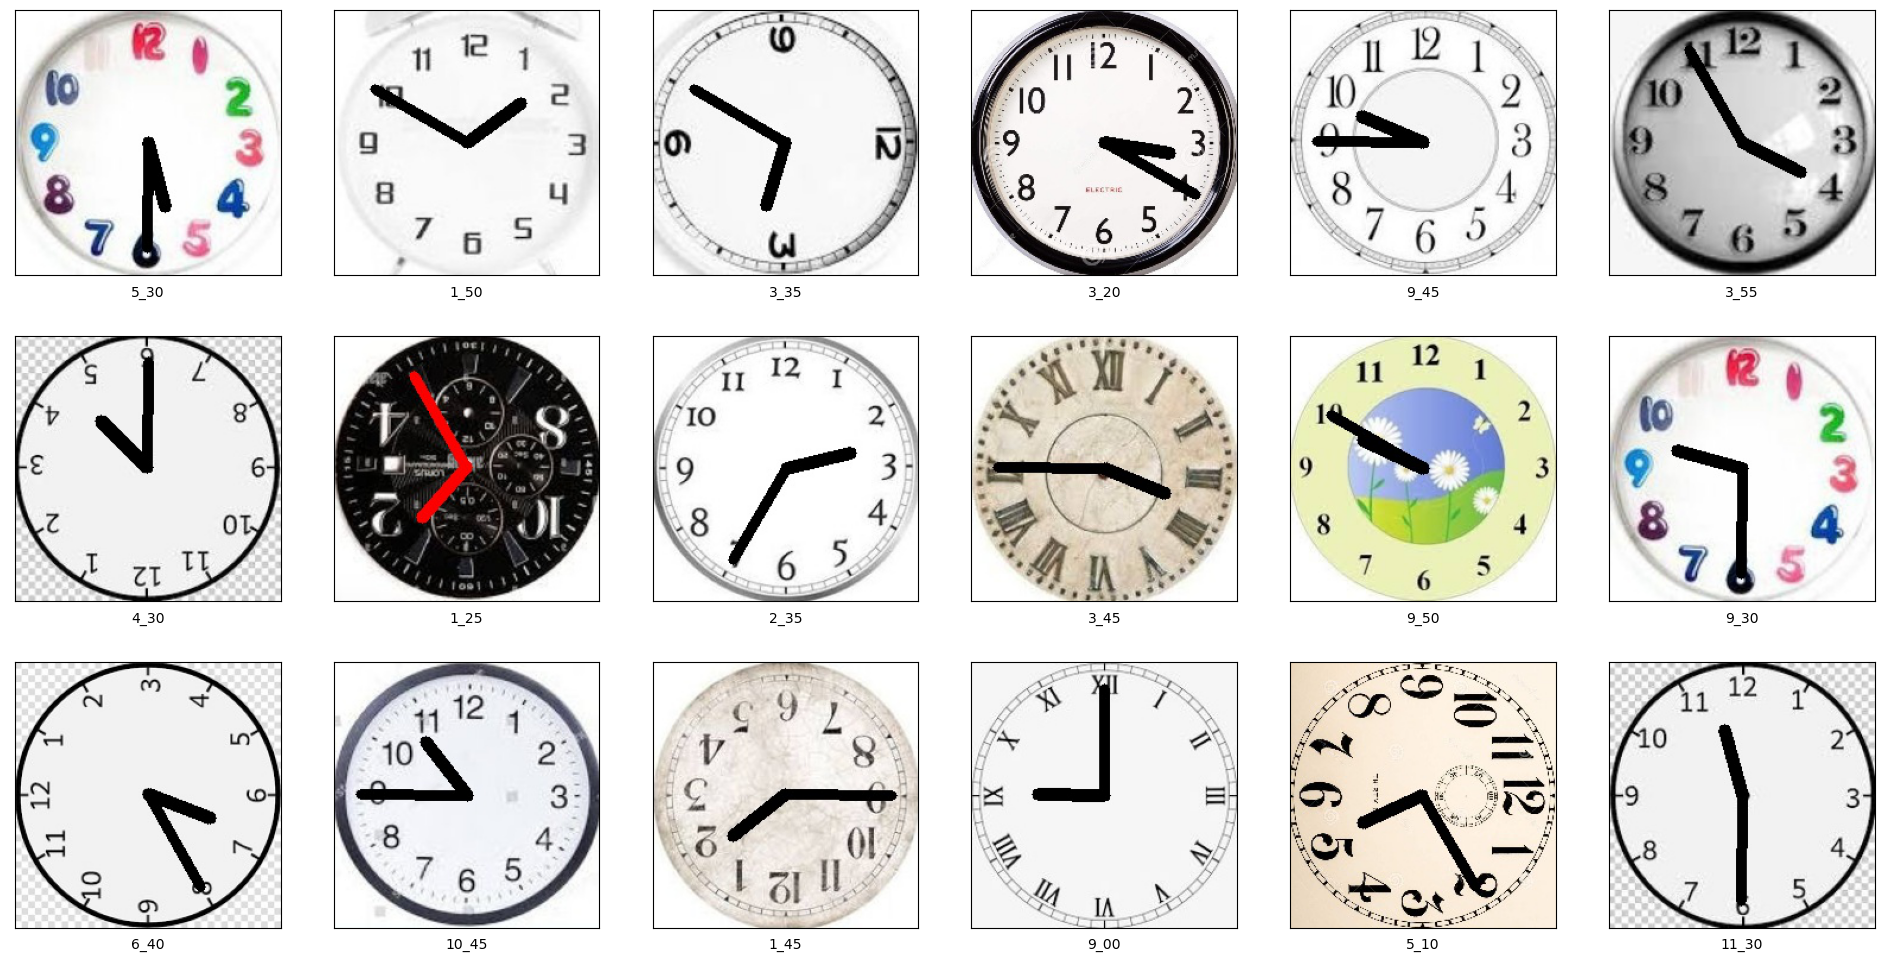

In [10]:
nrows = 3
ncols = 6



fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

idx = np.random.randint(0, len(train_images_dir), size=(nrows * ncols))

labels_filepaths = csv_data.loc[idx, ['labels','filepaths']].values
labels = csv_data.loc[idx, ['labels']].values
filepaths = csv_data.loc[idx, ['filepaths']].values
# next_images = csv_data['filepaths'].sample(n=nrows * ncols).values
print(idx)

for i, label in enumerate(labels):
  # coge el ndarray correcto y el elemento 0 ya que solo tiene ese valor
  img_path = filepaths[i][0]
  full_img_path = os.path.join(root_dir, img_path)

  sp = plt.subplot(nrows, ncols, i + 1)
  plt.xticks([])
  plt.yticks([]) 
  plt.grid(False)

  img = mpimg.imread(full_img_path)
  plt.imshow(img)
  plt.xlabel(label[0])

plt.show()

### Cargar las imagenes en memoria

In [11]:
train_images_full_dir = [root_dir + "/" +  fname for fname in train_images_dir]
train_images = np.array([cv2.imread(fname, ) for fname in train_images_full_dir])

test_images_full_dir = [root_dir + "/" +  fname for fname in test_images_dir]
test_images = np.array([cv2.imread(fname, ) for fname in test_images_full_dir])

valid_images_full_dir = [root_dir + "/" +  fname for fname in valid_images_dir]
valid_images = np.array([cv2.imread(fname, ) for fname in valid_images_full_dir])

In [12]:
print("Image shape", train_images[0].shape)

Image shape (224, 224, 3)


In [13]:
for image in train_images:
    if(train_images[0].shape != (224, 224, 3)):
        print("Image shape", image.shape)

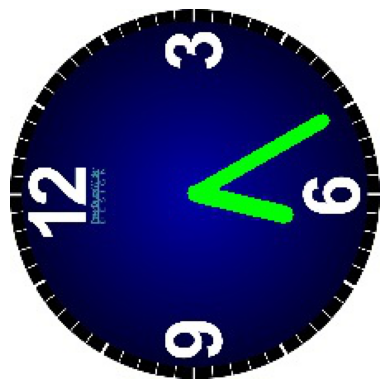

In [14]:
imshow(train_images[8154])

## Procesamiento de datos

In [23]:
model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(224, 224, 3)),
tf.keras.layers.Rescaling(1./255),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(144, activation='softmax')
]);


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)    

In [36]:
# model.compile(optimizer="rmsprop",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 3

history = model.fit(x= train_images, y=train_labels, epochs=epochs, batch_size=8, validation_data=(test_images, test_labels))

Epoch 1/3
